In [1]:
%matplotlib inline
import nengo.spa as spa
import numpy as np
import matplotlib.pyplot as plt

First, here's the SPA power function:

In [2]:
def power(s, e):
    x = np.fft.ifft(np.fft.fft(s.v) ** e).real
    return spa.SemanticPointer(data=x)


Here are two helper functions for computing the dot product over space, and for plotting the results

In [3]:
def spatial_dot(v, X, Y, xs, ys, transform=1):
    vs = np.zeros((len(ys),len(xs)))
    for i,x in enumerate(xs):
        for j, y in enumerate(ys):
            t = power(X, x)*power(Y,y)*transform
            vs[j,i] = np.dot(v.v, t.v)
    return vs

def spatial_plot(vs):
    vs = vs[::-1, :]
    plt.imshow(vs, interpolation='none', extent=(xs[0],xs[-1],ys[0],ys[-1]), vmax=1, vmin=-1, cmap='plasma')
    plt.colorbar()
        

Let's do a quick example of using the above functions to represent two items at (2,1.3) and (0,0.7)

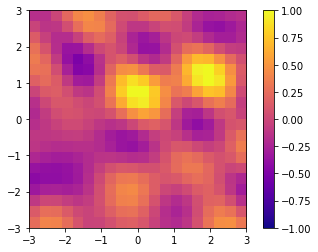

In [4]:
D = 64
X = spa.SemanticPointer(D)
X.make_unitary()
Y = spa.SemanticPointer(D)
Y.make_unitary()
xs = np.linspace(-3, 3, 20)
ys = np.linspace(-3, 3, 20)


v = power(X,2)*power(Y,1.3) + power(X,0)*power(Y,0.7)
vs = spatial_dot(v, X, Y, xs, ys)
spatial_plot(vs)

So, that lets us take a vector and turn it into a spatial map.  Now let's try going the other way around: specify a desired map, and find the vector that gives that.

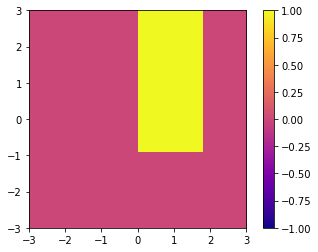

In [5]:
desired = np.zeros((len(xs),len(ys)))
for i,x in enumerate(xs):
    for j, y in enumerate(ys):
        if 0<x<2 and -1<y<=3:
            val = 1
        else:
            val = 0
        desired[j, i] = val
        
spatial_plot(desired)


Let's just treat this as an optimization problem.  It's fairly high-dimensional, so let's throw a genetic algorithm at it.

In [6]:
import scipy.optimize

def find_v(desired, X, Y, xs, ys, transform=1):    
    bounds = np.array([-np.ones_like(X.v), np.ones_like(X.v)]).T
    
    def objective(v):
        vs = spatial_dot(spa.SemanticPointer(data=v), X, Y, xs, ys, transform=transform)
        rmse = np.sqrt(np.mean((vs-desired)**2))
        return rmse
    result = scipy.optimize.differential_evolution(objective, maxiter=3, bounds=bounds)    
    return spa.SemanticPointer(data=result.x)
    
v = find_v(desired, X, Y, xs, ys)


That takes a while to run....

How well did it do?

In [7]:
vs = spatial_dot(v, X, Y, xs, ys)
rmse = np.sqrt(np.mean((vs-desired)**2))
print(rmse)

0.15142859457280508


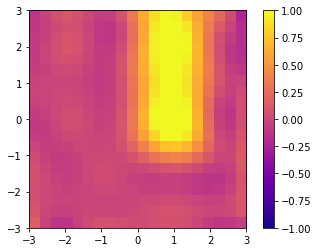

In [8]:
spatial_plot(spatial_dot(v, X, Y, xs, ys))

Yay!